## Working with forcing conditions

In [8]:
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

In [9]:
# Initialize SfincsModel with the artifact data catalog which contains data for North Italy
sf = SfincsModel(
    data_libs=["artifact_data"],
    root="tmp_example",
    mode="w+",
    logger=setuplog("", log_level=20),
)

2024-04-24 15:40:02,233 - root - log - INFO - HydroMT version: 0.9.5.dev0
2024-04-24 15:40:03,876 - root - data_catalog - INFO - Reading data catalog archive artifact_data v0.0.8
2024-04-24 15:40:03,877 - root - data_catalog - INFO - Parsing data catalog from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\data_catalog.yml
2024-04-24 15:40:04,066 - root - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


In [10]:
sf.setup_grid(
    x0=268650,
    y0=5018550,
    dx=150.0,
    dy=150.0,
    nmax=272,
    mmax=425,
    rotation=0,
    epsg=32633,
)

In [11]:
sf.setup_config(
    tref="20100201 000000",
    tstart="20100201 000000",
    tstop="20100210 000000",
)

In [12]:
import pandas as pd
import geopandas as gpd
import hydromt
import numpy as np
from hydromt_sfincs import utils
import xarray as xr

# Provided data
hs = [2, 2, 3]
tp = [10, 10, 11]
dir = [90, 90, 90]
ds = [20, 20, 20]
time = [0, 3600, 7200]

gdf = utils.read_xy("data//compound_wavelocs.txt", crs=sf.crs)


# Df with muplitple variables --> To x_array?
# What if time is not equal?

df_hs = pd.DataFrame(index= time, data = hs)
df_tp = pd.DataFrame(index= time, data = tp)
df_dir = pd.DataFrame(index= time, data = dir)
df_ds = pd.DataFrame(index= time, data = ds)

list_df = [df_hs, df_tp, df_dir, df_ds] 


sf.setup_wave_forcing(timeseries = list_df, locations= gdf)

gdf


,geometry
1,POINT (318671.890 5043342.740)


In [ ]:
sf.forcing

In [13]:
# data_hw = r".\data\hurrywave_his.nc"
# ds =  xr.open_mfdataset(data_hw)

# ds = ds.set_coords(["station_x", "station_y"])
# ds = ds.rename_vars({"point_hm0":"hs", "point_tp":"tp", "point_wavdir":"wd", "point_dirspr":"ds"})
# ds = ds.rename({"station_x": "lon", "station_y" : "lat", "stations": "index"})
# ds = ds.set_coords(["lon", "lat"])
# #ds = ds.set_index(stations = ["station_x", "station_y"], append = True )

# sf.setup_wave_forcing(ds)

# print("Hello")


In [14]:
sf.write_forcing()
#sf.forcing

2024-04-24 15:40:04,221 - root - sfincs - INFO - Write forcing files


ValueError: No geometry data found.

In [8]:
data_snapwave = r"c:\git\hydromt_sfincs\examples\tmp_example\snapwave.nc"
ds_SW =  xr.open_mfdataset(data_snapwave)
ds_SW

<xarray.Dataset>
Dimensions:      (index: 21, time: 19)
Coordinates:
    x            (index) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    y            (index) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2024-02-27 ... 2024-02-27T03:00:00
    spatial_ref  int32 ...
Dimensions without coordinates: index
Data variables:
    hs           (time, index) float32 dask.array<chunksize=(19, 21), meta=np.ndarray>
    tp           (time, index) float32 dask.array<chunksize=(19, 21), meta=np.ndarray>
    wd           (time, index) float32 dask.array<chunksize=(19, 21), meta=np.ndarray>
    ds           (time, index) float32 dask.array<chunksize=(19, 21), meta=np.ndarray>
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      Significant wave height Hm0 (m)

In [12]:
# 2d precip
sf.setup_precip_forcing_from_grid(
    precip="era5_hourly",
    aggregate=True,
)


2024-02-29 14:27:38,507 - root - rasterdataset - INFO - Reading era5_hourly netcdf data from C:\Users\asselt\.hydromt_data\artifact_data\v0.0.8\era5_hourly.nc


In [24]:
ds_precip = sf.data_catalog.get_geodataframe("era5_hourly")
ds_precip

TypeError: RasterDatasetAdapter.get_data() got an unexpected keyword argument 'predicate'

In [14]:
# 1d uniform precip
sf.setup_precip_forcing_from_grid(
    precip="era5_hourly",
    aggregate=True,
)

2024-02-29 14:27:40,105 - root - rasterdataset - INFO - Reading era5_hourly netcdf data from C:\Users\asselt\.hydromt_data\artifact_data\v0.0.8\era5_hourly.nc


2024-02-29 14:27:40,905 - root - model_api - WARNING - Replacing forcing: precip


2024-02-29 11:53:23,677 - root - dataframe - INFO - Reading  csv data from precip.csv


(<Figure size 600x300 with 1 Axes>,
 [<Axes: title={'center': 'SFINCS precipitation forcing (precip)'}, ylabel='precipitation\n[mm.hr-1]'>])

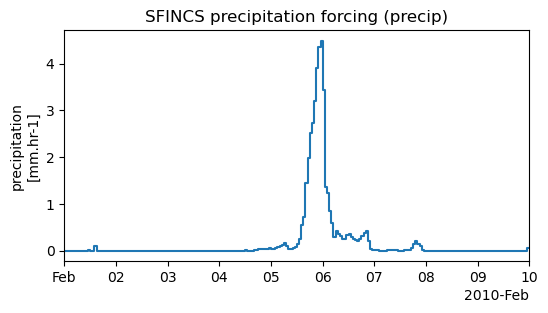

In [7]:
sf.forcing["precip"].to_pandas().to_csv("precip.csv")
sf.forcing.pop("precip", None)  # reset
sf.setup_precip_forcing(
    timeseries="precip.csv",
)
sf.plot_forcing()

(<Figure size 600x300 with 1 Axes>,
 [<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>])

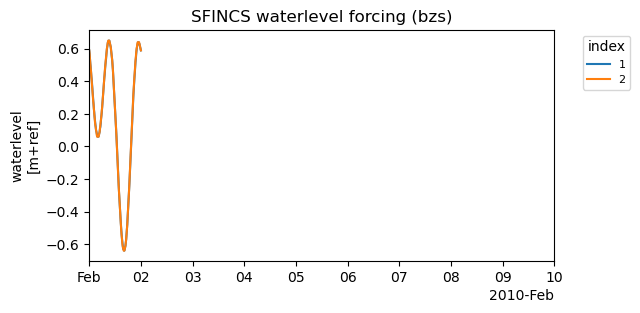

In [15]:
from hydromt_sfincs import utils

df = utils.read_timeseries("sfincs_compound//sfincs.bzs", tref=sf.config["tref"])
gdf = utils.read_xy("sfincs_compound//sfincs.bnd", crs=sf.crs)

sf.forcing.pop("bzs", None)  # reset
sf.forcing.pop("precip", None)  # reset

# add timeseries and locations
sf.setup_waterlevel_forcing(
    timeseries=df,
    locations=gdf,
    merge=True,
)
sf.plot_forcing()

2024-02-29 14:27:52,208 - root - rasterdataset - INFO - Reading dtu10mdt raster data from C:\Users\asselt\.hydromt_data\artifact_data\v0.0.8\dtu10mdt.tif


2024-02-29 14:27:52,462 - root - model_api - WARNING - Replacing forcing: bzs


(<Figure size 600x300 with 1 Axes>,
 [<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>])

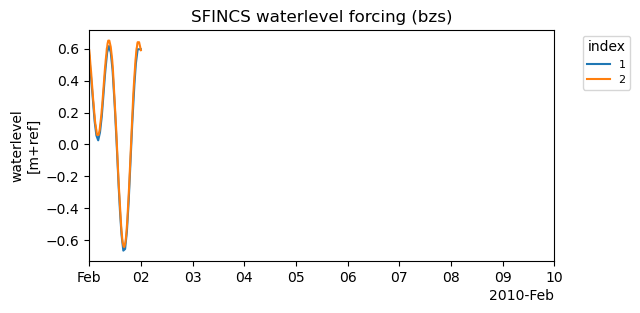

In [16]:
# merge (overwrite) existing timeseries with different time resoltiuon
# and add offset
sf.setup_waterlevel_forcing(
    timeseries=df.iloc[::5, [0]],
    locations=gdf.iloc[[0]],
    offset="dtu10mdt",
    merge=True,
)
sf.plot_forcing()

2024-02-29 14:27:53,949 - root - dataframe - INFO - Reading  csv data from waterlevel.csv


2024-02-29 14:27:54,177 - root - model_api - WARNING - Replacing forcing: bzs


(<Figure size 600x300 with 1 Axes>,
 [<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>])

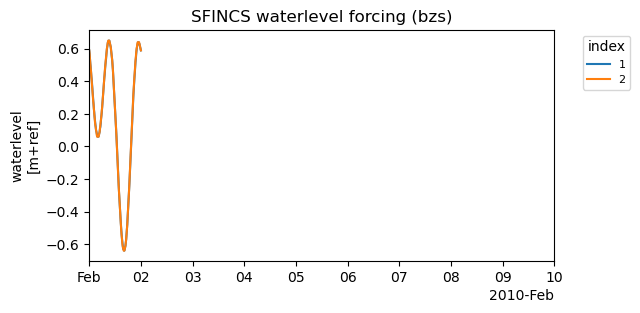

In [17]:
# update timeseries from csv
df.to_csv("waterlevel.csv")
sf.setup_waterlevel_forcing(
    timeseries="waterlevel.csv",
    merge=True,
)
sf.plot_forcing()

2024-02-29 14:27:55,373 - hydromt.data_adapter.geodataset - geodataset - INFO - Reading gtsmv3_eu_era5 netcdf data from C:\Users\asselt\.hydromt_data\artifact_data\v0.0.8\gtsmv3_eu_era5.nc


2024-02-29 14:27:56,263 - root - rasterdataset - INFO - Reading dtu10mdt raster data from C:\Users\asselt\.hydromt_data\artifact_data\v0.0.8\dtu10mdt.tif
2024-02-29 14:27:56,576 - root - model_api - WARNING - Replacing forcing: bzs


(<Figure size 600x300 with 1 Axes>,
 [<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>])

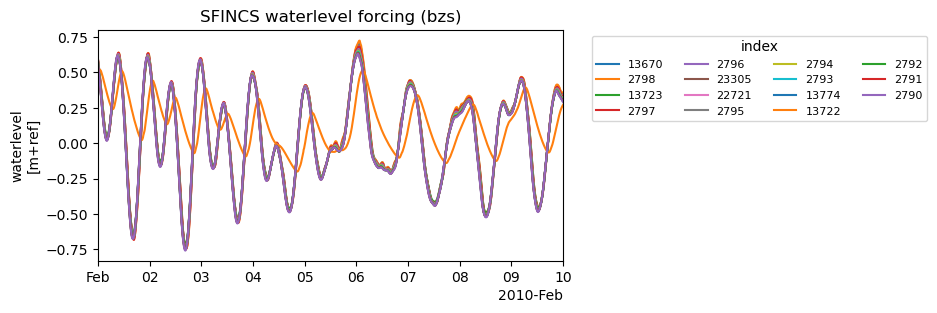

In [18]:
# overwrite forcing from geodataset (netcdf file)
sf.setup_waterlevel_forcing(
    geodataset="gtsmv3_eu_era5",
    offset="dtu10mdt",
    merge=False,
)
sf.plot_forcing()

In [19]:
sf.write_forcing()
sf.write_config()

2024-02-29 14:27:58,352 - root - sfincs - INFO - Write forcing files
2024-02-29 14:27:58,477 - root - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder


2024-02-29 14:28:16,938 - hydromt_sfincs.sfincs - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).
2024-02-29 14:28:17,109 - hydromt_sfincs.sfincs - sfincs - WARNING - Index in bndfile does not match c:\git\hydromt_sfincs\examples\tmp_example\gis\bnd.geojson


(<Figure size 600x600 with 2 Axes>,
 array([<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <Axes: title={'center': 'SFINCS precipitation forcing (precip)'}, ylabel='precipitation\n[mm.hr-1]'>],
       dtype=object))

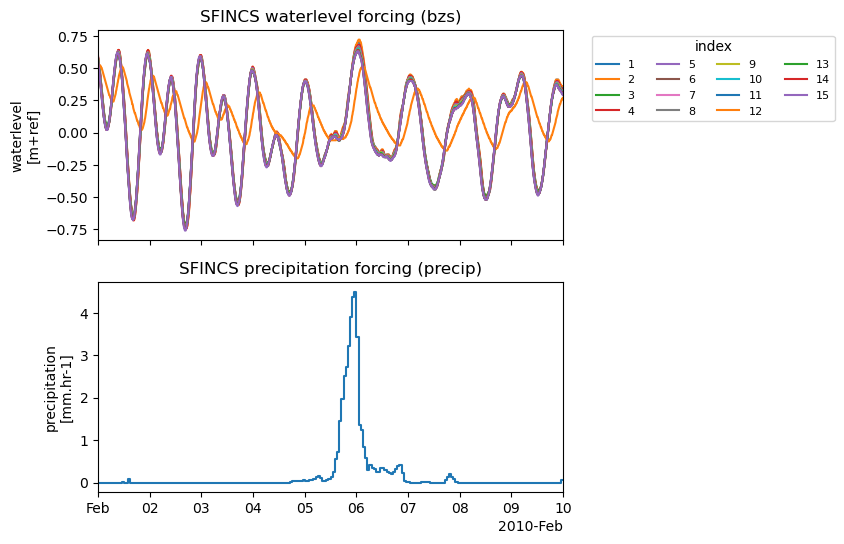

In [20]:
# note that index number cannot be saved in ascii timeseries format
# and are stored as attributes of the geojson file
sf1 = SfincsModel(sf.root, mode="r")  # read mode
sf1.read_forcing()
sf1.plot_forcing()

In [41]:
import importlib

importlib.reload(hydromt_sfincs)

NameError: name 'hydromt_sfincs' is not defined

SyntaxError: invalid syntax (3958753047.py, line 4)